In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

SNR estimated = nan[dB]
... Select the projective proj.


/var/folders/b3/3vgsg15j72gc54f0qpjcfkym0000gn/T/ipykernel_51147/312047622.py:16: RuntimeWarning: invalid value encountered in log10
  snr_est = 10*np.log10( (P_x - p/L*P_y)/(P_y - P_x) )


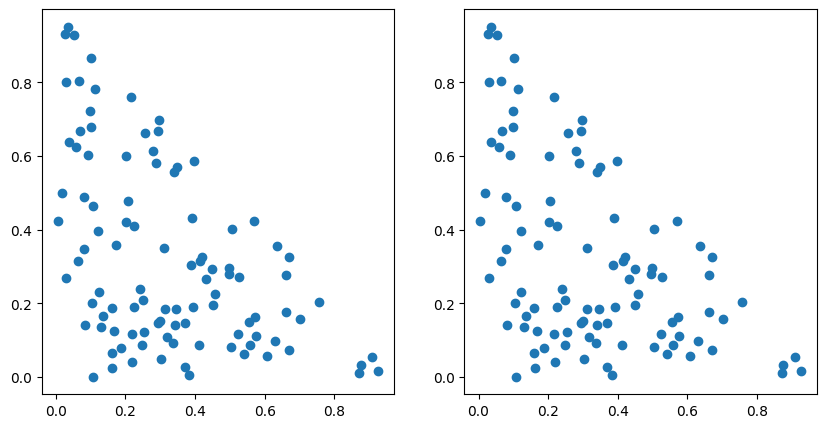

In [41]:
# -*- coding: utf-8 -*-
import sys
import numpy as np

#############################################
# Internal functions
#############################################

def estimate_snr(Y,r_m,x):

  [L, N] = Y.shape           # L number of bands (channels), N number of pixels
  [p, N] = x.shape           # p number of endmembers (reduced dimension)
  
  P_y     = np.sum(Y**2)/float(N)
  P_x     = np.sum(x**2)/float(N) + np.sum(r_m**2)
  snr_est = 10*np.log10( (P_x - p/L*P_y)/(P_y - P_x) )

  return snr_est

def vca(Y,R,verbose = True,snr_input = 0):
# Vertex Component Analysis
#
# Ae, indice, Yp = vca(Y,R,verbose = True,snr_input = 0)
#
# ------- Input variables -------------
#  Y - matrix with dimensions L(channels) x N(pixels)
#      each pixel is a linear mixture of R endmembers
#      signatures Y = M x s, where s = gamma x alfa
#      gamma is a illumination perturbation factor and
#      alfa are the abundance fractions of each endmember.
#  R - positive integer number of endmembers in the scene
#
# ------- Output variables -----------
# Ae     - estimated mixing matrix (endmembers signatures)
# indice - pixels that were chosen to be the most pure
# Yp     - Data matrix Y projected.   
#
# ------- Optional parameters---------
# snr_input - (float) signal to noise ratio (dB)
# v         - [True | False]
# ------------------------------------
#
# Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
# This code is a translation of a matlab code provided by 
# Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
# available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
# Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
#
# more details on:
# Jose M. P. Nascimento and Jose M. B. Dias 
# "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
# submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
# 
# 

  #############################################
  # Initializations
  #############################################
  if len(Y.shape)!=2:
    sys.exit('Input data must be of size L (number of bands i.e. channels) by N (number of pixels)')

  [L, N]=Y.shape   # L number of bands (channels), N number of pixels
       
  R = int(R)
  if (R<0 or R>L):  
    sys.exit('ENDMEMBER parameter must be integer between 1 and L')
        
  #############################################
  # SNR Estimates
  #############################################

  if snr_input==0:
    y_m = np.mean(Y,axis=1,keepdims=True)
    Y_o = Y - y_m           # data with zero-mean
    Ud  = np.linalg.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix 
    x_p = np.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace

    SNR = estimate_snr(Y,y_m,x_p);
    
    if verbose:
      print("SNR estimated = {}[dB]".format(SNR))
  else:
    SNR = snr_input
    if verbose:
      print("input SNR = {}[dB]\n".format(SNR))

  SNR_th = 15 + 10*np.log10(R)
         
  #############################################
  # Choosing Projective Projection or 
  #          projection to p-1 subspace
  #############################################

  if SNR < SNR_th:
    if verbose:
      print("... Select proj. to R-1")
                
      d = R-1
      if snr_input==0: # it means that the projection is already computed
        Ud = Ud[:,:d]
      else:
        y_m = np.mean(Y,axis=1,keepdims=True)
        Y_o = Y - y_m  # data with zero-mean 
         
        Ud  = np.linalg.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:d]  # computes the p-projection matrix 
        x_p =  np.dot(Ud.T,Y_o)                 # project thezeros mean data onto p-subspace
                
      Yp =  np.dot(Ud,x_p[:d,:]) + y_m      # again in dimension L
                
      x = x_p[:d,:] #  x_p =  Ud.T * Y_o is on a R-dim subspace
      c = np.amax(sp.sum(x**2,axis=0))**0.5
      y = np.vstack(( x, c*np.ones((1,N)) ))
  else:
    if verbose:
      print("... Select the projective proj.")
             
    d = R
    Ud  = np.linalg.svd(np.dot(Y,Y.T)/float(N))[0][:,:d] # computes the p-projection matrix 
                
    x_p = np.dot(Ud.T,Y)
    Yp =  np.dot(Ud,x_p[:d,:])      # again in dimension L (note that x_p has no null mean)
                
    x =  np.dot(Ud.T,Y)
    u = np.mean(x,axis=1,keepdims=True)        #equivalent to  u = Ud.T * r_m
    y =  x / ( np.dot(u.T,x) + 1e-7 )

 
  #############################################
  # VCA algorithm
  #############################################

  indice = np.zeros((R),dtype=int)
  A = np.zeros((R,R))
  A[-1,0] = 1

  for i in range(R):
    w = np.random.rand(R,1);   
    f = w - np.dot(A,np.dot(np.linalg.pinv(A),w))
    f = f / np.linalg.norm(f)
      
    v = np.dot(f.T,y)

    indice[i] = np.argmax(np.absolute(v))
    A[:,i] = y[:,indice[i]]        # same as x(:,indice(i))

  Ae = Yp[:,indice]

  return Ae,indice,Yp

def sample_from_2simplex(n_samples=1):
    x = np.random.exponential(scale=1.0, size=(n_samples, 3))
    return x / np.sum(x, axis=1, keepdims=True)
Y = sample_from_2simplex(100).T

Ae, indice, Yp = vca(Y, 3, verbose = True, snr_input = 0)

fig, ax = plt.subplots(
    1, 2, figsize=(10,5)
)

ax[0].plot(Y[0,:], Y[1,:], 'o', label='Original Data')
ax[1].plot(Yp[0,:], Yp[1,:], 'o', label='Projected Data')